# Рисование карты дефектов с помощью модели ver_10

In [1]:
# Подключенине библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
sys.path.append('custom_modules')

import Data_processing as dp

from matplotlib import ticker
from IPython.display import display
from tensorflow import keras

### Константы для путей к файлам

In [2]:
# Пути к обработанным данным
# Путь к X части выборки с массивами в каждой ячейке
# Run1 - данные обучающей выборки
# Run2 - данные тестовой выборки
path_to_array_like_X_data = 'data/Prepared data/Run2/X_data_array_like.xlsx'
# Путь к Y части выборки
path_to_Y_data = 'data/Prepared data/Run2/Y_data(binary_classification).xlsx'


### Константы для обработки данных

In [3]:
# Размер кропа
PREP_image_size = 64
# Шаг кропа
PREP_crop_step = 5

In [4]:
# Детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

### Функции для обработки

In [5]:
def extend_df_for_prediction_1(df, crop_size, crop_step):

    print('||||||||||||||||||')
    print('Df extending for better prediction')
    print('Original df size: ', df.shape)
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', crop_step)

    extend_dims = crop_size - 1
    
    df = pd.concat([df,df.iloc[:,:extend_dims]],axis=1,ignore_index=True)
    df = pd.concat([df,df.iloc[:extend_dims,:]],axis=0,ignore_index=True)
        
    print('New df shape: ', df.shape)
    print('||||||||||||||||||\n')

    dp.reshape_df_for_future_crops(df,crop_size,crop_step)
    
    return df

In [6]:
def extend_df_for_prediction_2(df, crop_size, crop_step):

    print('||||||||||||||||||')
    print('Df extending for better prediction')
    print('Original df size: ', df.shape)
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', crop_step)
        
    extend_dims = crop_size - 1

    df = pd.concat([df.iloc[:,-1 * extend_dims:],
                    df,
                    df.iloc[:,:extend_dims]],axis=1,ignore_index=True)
    
    df = pd.concat([df.iloc[extend_dims-1::-1,:], 
                    df,
                    df.iloc[-1:-extend_dims-1:-1,:]
                    ],axis=0,ignore_index=True)
        
    print('New df shape: ', df.shape)
    print('||||||||||||||||||\n')
    
    dp.reshape_df_for_future_crops(df,crop_size,crop_step)

    return df

### 3 подхода к предобработке

In [7]:
# Преобразовать массив результатов работы модели размера (batch,1)
# в матрицу размера PREP_df_rows * PREP_df_cols (карту дефектов, построенную моделью)
# Размер выходной матрицы - PREP_df_rows * PREP_df_cols
# Так как начальное расширение датафрейма на PREP_image_size по 2 осям
# тут учитывается грубо, то размер выходной матрицы будет также
# PREP_df_rows * PREP_df_cols, а ячейки по конрутру будут размыты 
# и не точны, так как по ним фильтр прошел меньше раз чем по ячейкам 
# посреди матрицы

def test_reshape_2D_Y_numpy_to_2D_0(rows_count, cols_count, crop_size, step = -1):

    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', step)

    if step == -1:
        step = crop_size
    
    new_arr = np.zeros((rows_count, cols_count))
      
    for j in range(0,  cols_count - crop_size + 1, step):
        for i in range(0, rows_count - crop_size + 1, step):
            new_arr[i:i+crop_size,j:j+crop_size] += 1      
            
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')

    return new_arr

In [8]:
# Преобразовать массив результатов работы модели размера (batch,1)
# Так как начальное расширение датафрейма на crop_size по 2 осям

def test_reshape_2D_Y_numpy_to_2D_1(rows_count, cols_count, crop_size, step = -1):

    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', step)
    print(f'Expanded map size: ({rows_count},{cols_count})')
    print()

    new_rows = rows_count - crop_size + 1
    new_cols = cols_count - crop_size + 1
    
    new_arr = np.zeros((new_rows,new_cols))  
    
    add_num = 1
    
    for j in range(0,  cols_count - crop_size + 1, step):
        for i in range(0, rows_count - crop_size + 1, step):
            
            if i <= new_rows - crop_size:
                if j <= new_cols - crop_size:
                    temp_orig = new_arr[i:i+crop_size,j:j+crop_size] + add_num
                    new_arr[i:i+crop_size,j:j+crop_size] = temp_orig  
                elif j <= new_cols:
                    right_orig = new_arr[i:i+crop_size,j:] + add_num
                    left_orig = new_arr[i:i+crop_size,:crop_size - right_orig.shape[1]] + add_num
                    new_arr[i:i+crop_size,j:] = right_orig
                    new_arr[i:i+crop_size,:crop_size - right_orig.shape[1]] = left_orig

            elif i <= new_rows:
                if j <= new_cols - crop_size:
                    low_orig = new_arr[i:,j:j+crop_size] + add_num
                    high_orig = new_arr[:crop_size - low_orig.shape[0],j:j+crop_size] + add_num
                    new_arr[i:,j:j+crop_size] = low_orig 
                    new_arr[:crop_size - low_orig.shape[0],j:j+crop_size] = high_orig 
                elif j <= new_cols:
                    right_low = new_arr[i:,j:] + add_num
                    right_high = new_arr[:crop_size - low_orig.shape[0],j:] + add_num
                    
                    left_low = new_arr[i:,:crop_size - right_high.shape[1]] + add_num
                    left_high = new_arr[:crop_size - low_orig.shape[0],:crop_size - right_high.shape[1]] + add_num
                    
                    new_arr[i:,j:] = right_low
                    new_arr[:crop_size - low_orig.shape[0],j:] = right_high
                    new_arr[i:,:crop_size - right_high.shape[1]] = left_low
                    new_arr[:crop_size - low_orig.shape[0],:crop_size - right_high.shape[1]] = left_high
                          
            
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')

    return new_arr

In [9]:
# Преобразовать массив результатов работы модели размера (batch,1)
# в матрицу размера PREP_df_rows * PREP_df_cols (карту дефектов, построенную моделью)
# Размер выходной матрицы - PREP_df_rows * PREP_df_cols
# Так как начальное расширение датафрейма на PREP_image_size по 2 осям
# тут учитывается грубо, то размер выходной матрицы будет также
# PREP_df_rows * PREP_df_cols, а ячейки по конрутру будут размыты 
# и не точны, так как по ним фильтр прошел меньше раз чем по ячейкам 
# посреди матрицы

def test_reshape_2D_Y_numpy_to_2D_2(orig_rows_count, orig_cols_count,
                                    result_rows_count, result_cols_count, 
                                    crop_size, step = -1):

    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', step)

    if step == -1:
        step = crop_size
    
    new_arr = np.zeros((result_rows_count, result_cols_count))
      
    for j in range(0,  result_cols_count - crop_size + 1, step):
        for i in range(0, result_rows_count - crop_size + 1, step):
            new_arr[i:i+crop_size,j:j+crop_size] += 1      
    
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')

    left_up_border = crop_size - 1
    right_border = result_cols_count - (result_cols_count - orig_cols_count) + 1
    bottom_border = result_rows_count - (result_rows_count - orig_rows_count) + 1
    
    return new_arr[left_up_border:,left_up_border:][:orig_rows_count,:orig_cols_count]

In [10]:
test_rows = 115
test_cols = 400
test_crop_size = 64
test_step = PREP_crop_step
print('||||||||||||||||||||||||||||||||||||df_0||||||||||||||||||||||||||||||')
df_0 = pd.DataFrame(np.zeros((test_rows, test_cols)))
print(f'df.shape: ', df_0.shape)
print('||||||||||||||||||||||||||||||||||||df_1||||||||||||||||||||||||||||||')
df_1 = extend_df_for_prediction_1(df_0, test_crop_size, test_step)
print('||||||||||||||||||||||||||||||||||||df_2||||||||||||||||||||||||||||||')
df_2 = extend_df_for_prediction_2(df_0, test_crop_size, test_step)

#display(df_0)
#display(df_1)
#display(df_2)

||||||||||||||||||||||||||||||||||||df_0||||||||||||||||||||||||||||||
df.shape:  (115, 400)
||||||||||||||||||||||||||||||||||||df_1||||||||||||||||||||||||||||||
||||||||||||||||||
Df extending for better prediction
Original df size:  (115, 400)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New df shape:  (178, 463)
||||||||||||||||||

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (178, 463)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New df shape:  (179, 464)
||||||||||||||||||

||||||||||||||||||||||||||||||||||||df_2||||||||||||||||||||||||||||||
||||||||||||||||||
Df extending for better prediction
Original df size:  (115, 400)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New df shape:  (241, 526)
||||||||||||||||||

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (241, 526)
Crop windows height/width:  64
Crop windows

In [11]:
test_res_0 = test_reshape_2D_Y_numpy_to_2D_0(df_0.shape[0], df_0.shape[1], 
                                        test_crop_size, test_step)
test_res_1 = test_reshape_2D_Y_numpy_to_2D_1(df_1.shape[0], df_1.shape[1], 
                                        test_crop_size, test_step)
test_res_2 = test_reshape_2D_Y_numpy_to_2D_2(test_rows, test_cols, 
                                        df_2.shape[0], df_2.shape[1], 
                                        test_crop_size, test_step)

||||||||||||||||||
Y arr reshaping to 2D
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New numpy shape:  (115, 400)
||||||||||||||||||

||||||||||||||||||
Y arr reshaping to 2D
Crop windows height/width:  64
Crop windows step across rows and cols:  5
Expanded map size: (178,463)

New numpy shape:  (115, 400)
||||||||||||||||||

||||||||||||||||||
Y arr reshaping to 2D
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New numpy shape:  (241, 526)
||||||||||||||||||



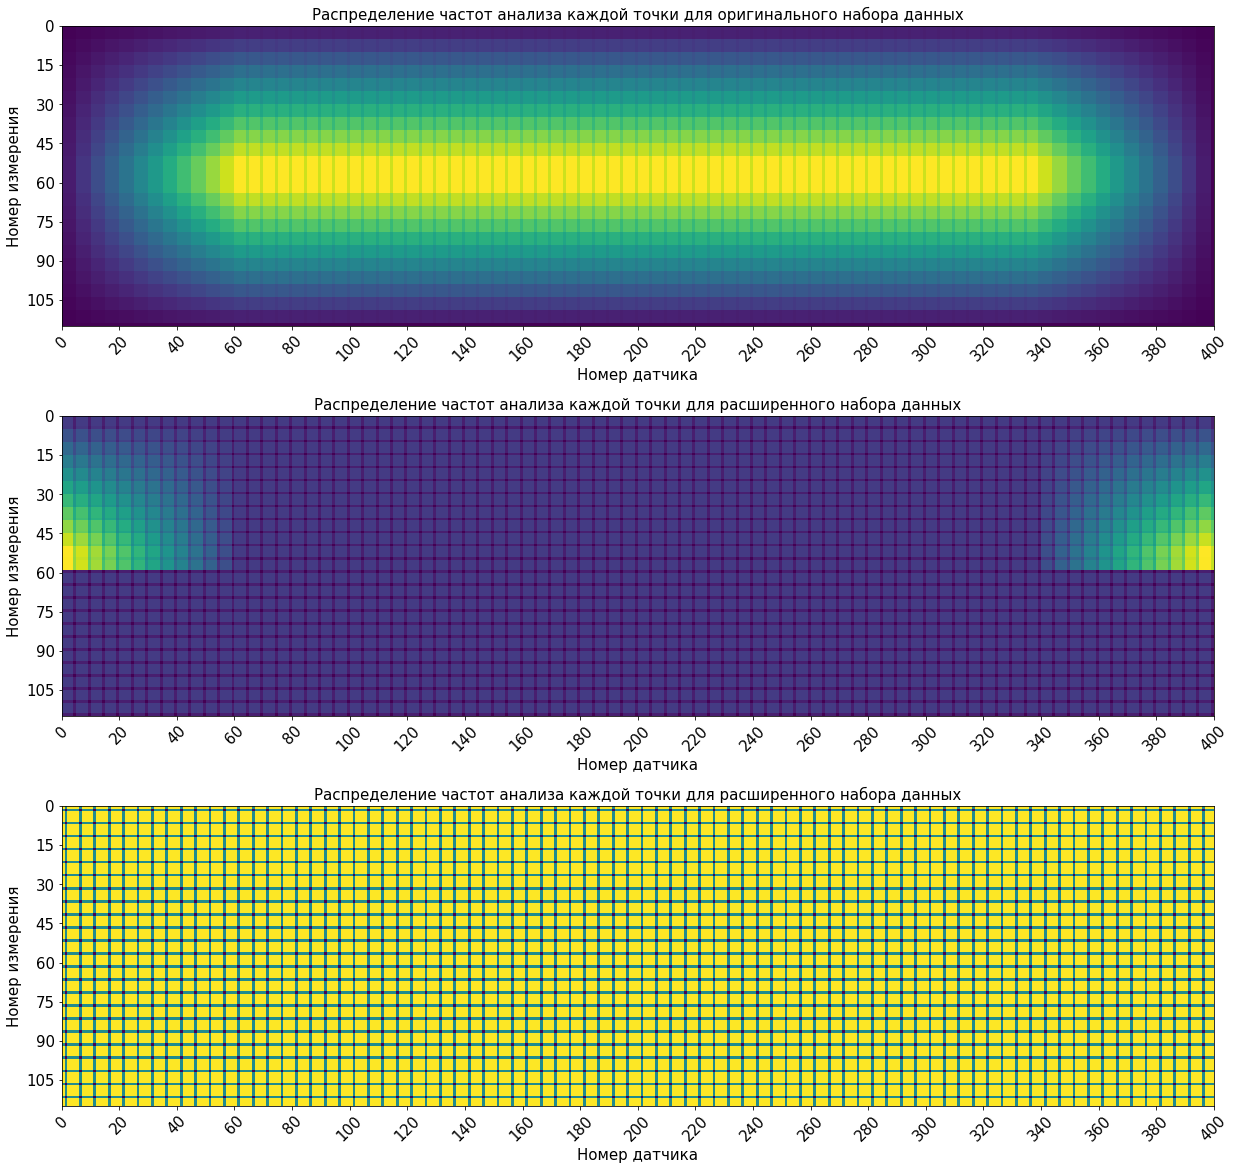

In [12]:
# Построить карту дефектов для считанного файла
# до всяких обработок
fig, axes = plt.subplots(3)

fig.set_figwidth(16)
fig.set_figheight(15)

axes[0].pcolormesh(test_res_0)
axes[0].invert_yaxis()

axes[0].set_xlabel('Номер датчика', fontsize=15) 
axes[0].set_ylabel('Номер измерения', fontsize=15) 
axes[0].set_title(f'Распределение частот анализа каждой точки для оригинального набора данных', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes[0].xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes[0].yaxis.set_tick_params(which = 'major', labelsize = 15) 

##############################################################################################

axes[1].pcolormesh(test_res_1)
axes[1].invert_yaxis()

axes[1].set_xlabel('Номер датчика', fontsize=15) 
axes[1].set_ylabel('Номер измерения', fontsize=15) 
axes[1].set_title(f'Распределение частот анализа каждой точки для расширенного набора данных', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes[1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes[1].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes[1].xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes[1].yaxis.set_tick_params(which = 'major', labelsize = 15) 

##############################################################################################

axes[2].pcolormesh(test_res_2)
axes[2].invert_yaxis()

axes[2].set_xlabel('Номер датчика', fontsize=15) 
axes[2].set_ylabel('Номер измерения', fontsize=15) 
axes[2].set_title(f'Распределение частот анализа каждой точки для расширенного набора данных', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes[2].xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes[2].yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes[2].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes[2].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes[2].xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes[2].yaxis.set_tick_params(which = 'major', labelsize = 15) 

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0.3)

plt.show()

# Загрузка данных

In [13]:
# загрузка данных из файлов
X_dict = dict()
Y_dict = dict()

X_dict['df'] =  dp.get_array_like_X_df(path_to_array_like_X_data)#.iloc[:,200:]
Y_dict['df'] =  dp.get_Y_df(path_to_Y_data)#.iloc[:,:200]

# По желанию сдвиг по оси у
#shift = 100

#X_dict['df'] = pd.concat([X_dict['df'].iloc[:,shift:],X_dict['df'].iloc[:,:shift]],axis=1,ignore_index=True)
#Y_dict['df'] = pd.concat([Y_dict['df'].iloc[:,shift:],Y_dict['df'].iloc[:,:shift]],axis=1,ignore_index=True)

In [14]:
# Запишем размеры датафреймов до обработки
ORIG_df_cols = Y_dict['df'].shape[1]
ORIG_df_rows = Y_dict['df'].shape[0]

### Оригинальная развернутая карта дефектов

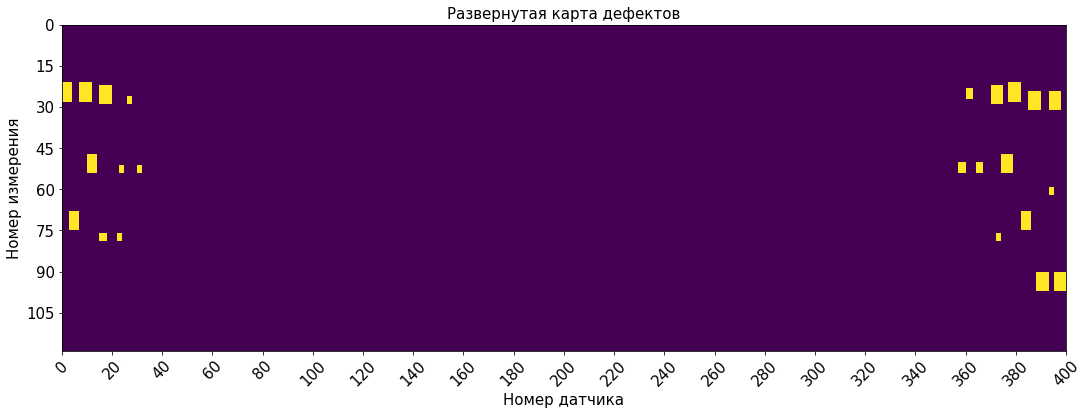

In [15]:
# Построить карту дефектов для считанного файла
# до всяких обработок
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(Y_dict['df'])
axes.invert_yaxis()

axes.set_xlabel('Номер датчика', fontsize=15) 
axes.set_ylabel('Номер измерения', fontsize=15) 
axes.set_title(f'Развернутая карта дефектов', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes.yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes.yaxis.set_tick_params(which = 'major', labelsize = 15) 

plt.show()

# Обработка данных

In [16]:
# Добавление строк в датафреймы
# Справа к каждому датафрейму дописывается по 64
# элемента, чтобы сымитировать сканирование 
# трубы по всей окружности фильтром размера 64 на 64
# а еще дописывается некоторое количество строк и столбцов
# меньшее чем шаг кропа. Чтобы датафрейм можно было поделить
# на целое кол-во кропов

print('||||||||||| X df preprocessing |||||||||||')
#X_dict['df'] = dp.reshape_df_for_future_crops(X_dict['df'], PREP_image_size, PREP_crop_step)
X_dict['df'] = extend_df_for_prediction_2(X_dict['df'], PREP_image_size, PREP_crop_step)

print('||||||||||| Y df preprocessing |||||||||||')
#Y_dict['df'] = dp.reshape_df_for_future_crops(Y_dict['df'], PREP_image_size, PREP_crop_step)
Y_dict['df'] = extend_df_for_prediction_2(Y_dict['df'], PREP_image_size, PREP_crop_step)

||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
Df extending for better prediction
Original df size:  (119, 400)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New df shape:  (245, 526)
||||||||||||||||||

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (245, 526)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New df shape:  (249, 529)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Df extending for better prediction
Original df size:  (119, 400)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New df shape:  (245, 526)
||||||||||||||||||

||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (245, 526)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New df shape:  (249, 529)
||||||||||||||||||



### Константы для обработки данных

In [17]:
# Запишем размеры датафреймов после обработки
PREP_df_cols = Y_dict['df'].shape[1]
PREP_df_rows = Y_dict['df'].shape[0]

### Расширенная развернутая карта дефектов

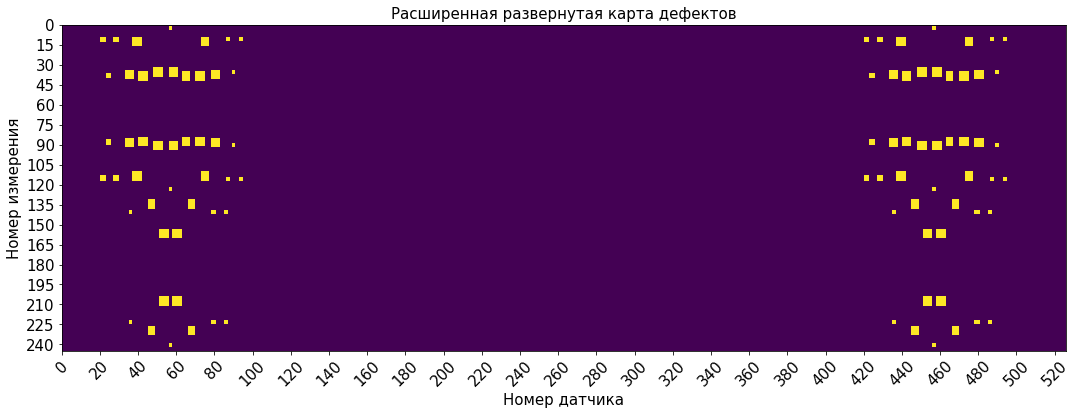

In [18]:
# Выведем карту дефектов после первичного расширения
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(Y_dict['df'])
axes.invert_yaxis()
axes.set_xlabel('Номер датчика', fontsize=15) 
axes.set_ylabel('Номер измерения', fontsize=15) 
axes.set_title(f'Расширенная развернутая карта дефектов', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes.yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes.yaxis.set_tick_params(which = 'major', labelsize = 15) 

plt.show()

In [19]:
# Запишем в словарь numpy array нарезанные из считанных датафреймов

print('||||||||||| X df preprocessing |||||||||||')
x_time_temp, \
x_amp_temp = dp.reshape_X_df_to_image_like_numpy(X_dict['df'], 
                                                    PREP_image_size, 
                                                    PREP_crop_step)
X_dict['X_time_all'] = x_time_temp.astype('float32')
X_dict['X_amp_all'] = x_amp_temp.astype('float32')

X_dict.pop('df',0)
print()

||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
X df reshaping to 4D
Original df size:  (245, 526)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New X_time shape:  (3441, 64, 64, 32)
New X_amp shape:  (3441, 64, 64, 32)
||||||||||||||||||




In [20]:
# что есть на данный момент

print('|||||||||||||| X dataset ||||||||||||||||')
for key in X_dict.keys():
    print(f"{key}.shape: ", X_dict[key].shape)

print('\n|||||||||||||| Y dataset ||||||||||||||||')
for key in Y_dict.keys():
    print(f"{key}.shape: ", Y_dict[key].shape)

|||||||||||||| X dataset ||||||||||||||||
X_time_all.shape:  (3441, 64, 64, 32)
X_amp_all.shape:  (3441, 64, 64, 32)

|||||||||||||| Y dataset ||||||||||||||||
df.shape:  (245, 526)


In [21]:
# нормализация данных

print('|||||||||||||| X dataset ||||||||||||||||')
for key in X_dict.keys():
    print(f"|||||||||||||| dataset part: {key}||||||||||||||||")
    X_dict[key] = dp.normalize_data(X_dict[key])

|||||||||||||| X dataset ||||||||||||||||
|||||||||||||| dataset part: X_time_all||||||||||||||||
||||||||||||||||||
Data normalizing
arr_max before normalization: 44.400001525878906
arr_max after normalization: 1.0
arr_min after normalization: 0.0
||||||||||||||||||
|||||||||||||| dataset part: X_amp_all||||||||||||||||
||||||||||||||||||
Data normalizing
arr_max before normalization: 62.992000579833984
arr_max after normalization: 1.0
arr_min after normalization: -0.9919037222862244
||||||||||||||||||


In [22]:
# объединение данных в тестовую выборку

X_time_test = X_dict['X_time_all']                              
X_dict.pop('X_time_all',0)


X_amp_test = X_dict['X_amp_all']
X_dict.pop('X_amp_all',0)

print()

In [23]:
# очистка памяти от лишнего   

X_dict.clear()
Y_dict.clear()

In [24]:
# сколько получилось тестовых данных
print('X_time_test.shape: ', X_time_test.shape)
print('X_amp_test.shape: ', X_amp_test.shape)
print('\n')

X_time_test.shape:  (3441, 64, 64, 32)
X_amp_test.shape:  (3441, 64, 64, 32)




# CNN с 2 входами по времени и амплитуде

### Функции для дешифровки результатов

In [25]:
# Преобразовать массив результатов работы модели размера (batch,1)
# в матрицу размера PREP_df_rows * PREP_df_cols (карту дефектов, построенную моделью)
# Размер выходной матрицы - PREP_df_rows * PREP_df_cols
# Так как начальное расширение датафрейма на PREP_image_size по 2 осям
# тут учитывается грубо, то размер выходной матрицы будет также
# PREP_df_rows * PREP_df_cols, а ячейки по конрутру будут размыты 
# и не точны, так как по ним фильтр прошел меньше раз чем по ячейкам 
# посреди матрицы

def reshape_2D_Y_numpy_to_2D_0_0(arr, rows_count, cols_count, crop_size, step = -1):

    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Original arr size: ', arr.shape)
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', step)

    if step == -1:
        step = crop_size
    
    new_arr = np.zeros((rows_count, cols_count))
    
    arr = arr[:,0]
    myit = iter(arr)    
    
    for j in range(0,  cols_count - crop_size + 1, step):
        for i in range(0, rows_count - crop_size + 1, step):
            temp_add = next(myit)
            temp_orig = new_arr[i:i+crop_size,j:j+crop_size]
            
            if temp_add > 0.5:
                temp_orig = temp_orig + temp_add
            if temp_add <= 0.5:
                temp_orig = temp_orig - temp_add
            
            new_arr[i:i+crop_size,j:j+crop_size] = temp_orig       
            
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')

    return new_arr

In [26]:
# Преобразовать массив результатов работы модели размера (batch,1)
# в матрицу размера PREP_df_rows * PREP_df_cols (карту дефектов, построенную моделью)
# Размер выходной матрицы - PREP_df_rows * PREP_df_cols
# Так как начальное расширение датафрейма на PREP_image_size по 2 осям
# тут учитывается грубо, то размер выходной матрицы будет также
# PREP_df_rows * PREP_df_cols, а ячейки по конрутру будут размыты 
# и не точны, так как по ним фильтр прошел меньше раз чем по ячейкам 
# посреди матрицы

def reshape_2D_Y_numpy_to_2D_0_1(arr, rows_count, cols_count, crop_size, step = -1):

    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Original arr size: ', arr.shape)
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', step)

    if step == -1:
        step = crop_size
    
    new_arr = np.ones((rows_count, cols_count))
    
    arr = arr[:,0]
    myit = iter(arr)    
    
    for j in range(0,  cols_count - crop_size + 1, step):
        for i in range(0, rows_count - crop_size + 1, step):
            temp_add = next(myit)
            temp_orig = new_arr[i:i+crop_size,j:j+crop_size]
            
            if temp_add > 0.5:
                temp_orig = temp_orig * 1.1
            if temp_add <= 0.5:
                temp_orig = temp_orig / 1.1
            
            new_arr[i:i+crop_size,j:j+crop_size] = temp_orig       
            
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')

    return new_arr

In [27]:
# Преобразовать массив результатов работы модели размера (batch,1)
# в матрицу размера PREP_df_rows * PREP_df_cols (карту дефектов, построенную моделью)
# Размер выходной матрицы - PREP_df_rows * PREP_df_cols
# Так как начальное расширение датафрейма на PREP_image_size по 2 осям
# тут учитывается грубо, то размер выходной матрицы будет также
# PREP_df_rows * PREP_df_cols, а ячейки по конрутру будут размыты 
# и не точны, так как по ним фильтр прошел меньше раз чем по ячейкам 
# посреди матрицы

def reshape_2D_Y_numpy_to_2D_0_2(arr, rows_count, cols_count, crop_size, step = -1):

    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Original arr size: ', arr.shape)
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', step)

    if step == -1:
        step = crop_size
    
    new_arr = np.ones((rows_count, cols_count))
    
    arr = arr[:,0]
    myit = iter(arr)    
    
    for j in range(0,  cols_count - crop_size + 1, step):
        for i in range(0, rows_count - crop_size + 1, step):
            temp_add = next(myit)
            temp_orig = new_arr[i:i+crop_size,j:j+crop_size]
            
            if temp_add > 0.5:
                temp_orig = temp_orig ** (1.1)
            if temp_add <= 0.5:
                temp_orig = temp_orig / 2
            
            new_arr[i:i+crop_size,j:j+crop_size] = temp_orig       
            
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')

    return new_arr

In [28]:
# Преобразовать массив результатов работы модели размера (batch,1)
# Так как начальное расширение датафрейма на crop_size по 2 осям

def reshape_2D_Y_numpy_to_2D_1_0(arr, rows_count, cols_count, crop_size, step = -1):

    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Crops arr size: ', arr.shape)
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', step)
    print(f'Expanded map size: ({rows_count},{cols_count})')
    print()

    new_rows = rows_count - crop_size + 1
    new_cols = cols_count - crop_size + 1
    
    new_arr = np.zeros((new_rows,new_cols))
    
    arr = arr[:,0]
    myit = iter(arr)    
    
    for j in range(0,  cols_count - crop_size + 1, step):
        for i in range(0, rows_count - crop_size + 1, step):
            temp_add_num = next(myit)
            if temp_add_num > 0.5:
                add_num = 0.1
            if temp_add_num <= 0.5:
                add_num = - 0.1

            if i <= new_rows - crop_size:
                if j <= new_cols - crop_size:
                    temp_orig = new_arr[i:i+crop_size,j:j+crop_size] + add_num
                    new_arr[i:i+crop_size,j:j+crop_size] = temp_orig  
                elif j <= new_cols:
                    right_orig = new_arr[i:i+crop_size,j:] + add_num
                    left_orig = new_arr[i:i+crop_size,:crop_size - right_orig.shape[1]] + add_num
                    new_arr[i:i+crop_size,j:] = right_orig
                    new_arr[i:i+crop_size,:crop_size - right_orig.shape[1]] = left_orig

            elif i <= new_rows:
                if j <= new_cols - crop_size:
                    low_orig = new_arr[i:,j:j+crop_size] + add_num
                    high_orig = new_arr[:crop_size - low_orig.shape[0],j:j+crop_size] + add_num
                    new_arr[i:,j:j+crop_size] = low_orig 
                    new_arr[:crop_size - low_orig.shape[0],j:j+crop_size] = high_orig 
                elif j <= new_cols:
                    right_low = new_arr[i:,j:] + add_num
                    right_high = new_arr[:crop_size - low_orig.shape[0],j:] + add_num
                    
                    left_low = new_arr[i:,:crop_size - right_high.shape[1]] + add_num
                    left_high = new_arr[:crop_size - low_orig.shape[0],:crop_size - right_high.shape[1]] + add_num
                    
                    new_arr[i:,j:] = right_low
                    new_arr[:crop_size - low_orig.shape[0],j:] = right_high
                    new_arr[i:,:crop_size - right_high.shape[1]] = left_low
                    new_arr[:crop_size - low_orig.shape[0],:crop_size - right_high.shape[1]] = left_high
                          
            
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')

    return new_arr

In [29]:
# Преобразовать массив результатов работы модели размера (batch,1)
# в матрицу размера PREP_df_rows * PREP_df_cols (карту дефектов, построенную моделью)
# Размер выходной матрицы - PREP_df_rows * PREP_df_cols
# Так как начальное расширение датафрейма на PREP_image_size по 2 осям
# тут учитывается грубо, то размер выходной матрицы будет также
# PREP_df_rows * PREP_df_cols, а ячейки по конрутру будут размыты 
# и не точны, так как по ним фильтр прошел меньше раз чем по ячейкам 
# посреди матрицы

# y = x + k
def reshape_2D_Y_numpy_to_2D_2_0(arr, orig_rows_count, orig_cols_count,
                                    result_rows_count, result_cols_count, 
                                    crop_size, step = -1):

    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', step)

    if step == -1:
        step = crop_size
    
    new_arr = np.zeros((result_rows_count, result_cols_count))
      
    arr = arr[:,0]
    myit = iter(arr)    
        
    for j in range(0,  result_cols_count - crop_size + 1, step):
        for i in range(0, result_rows_count - crop_size + 1, step):
            temp_add = next(myit)
            temp_orig = new_arr[i:i+crop_size,j:j+crop_size]
            
            if temp_add > 0.5:
                temp_orig = temp_orig + temp_add
            if temp_add <= 0.5:
                temp_orig = temp_orig - temp_add
            
            new_arr[i:i+crop_size,j:j+crop_size] = temp_orig       
    

    left_up_border = crop_size - 1
    right_border = result_cols_count - (result_cols_count - orig_cols_count) + 1
    bottom_border = result_rows_count - (result_rows_count - orig_rows_count) + 1
    
    new_arr = new_arr[left_up_border:,left_up_border:][:orig_rows_count,:orig_cols_count]
    
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')
    
    return new_arr

In [30]:
# Преобразовать массив результатов работы модели размера (batch,1)
# в матрицу размера PREP_df_rows * PREP_df_cols (карту дефектов, построенную моделью)
# Размер выходной матрицы - PREP_df_rows * PREP_df_cols
# Так как начальное расширение датафрейма на PREP_image_size по 2 осям
# тут учитывается грубо, то размер выходной матрицы будет также
# PREP_df_rows * PREP_df_cols, а ячейки по конрутру будут размыты 
# и не точны, так как по ним фильтр прошел меньше раз чем по ячейкам 
# посреди матрицы

# y = kx
def reshape_2D_Y_numpy_to_2D_2_1(arr, orig_rows_count, orig_cols_count,
                                    result_rows_count, result_cols_count, 
                                    crop_size, step = -1):

    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', step)

    if step == -1:
        step = crop_size
    
    new_arr = np.ones((result_rows_count, result_cols_count)).astype('float32')
      
    arr = arr[:,0]
    myit = iter(arr)    
        
    for j in range(0,  result_cols_count - crop_size + 1, step):
        for i in range(0, result_rows_count - crop_size + 1, step):
            temp_add = next(myit)
            temp_orig = new_arr[i:i+crop_size,j:j+crop_size]
            
            if temp_add > 0.5:
                temp_orig = temp_orig * 1.1
            if temp_add <= 0.5:
                temp_orig = temp_orig / 1.1
            
            new_arr[i:i+crop_size,j:j+crop_size] = temp_orig       
    

    left_up_border = crop_size - 1
    right_border = result_cols_count - (result_cols_count - orig_cols_count) + 1
    bottom_border = result_rows_count - (result_rows_count - orig_rows_count) + 1
    
    new_arr = new_arr[left_up_border:,left_up_border:][:orig_rows_count,:orig_cols_count]
    
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')
    
    return new_arr

In [31]:
# Преобразовать массив результатов работы модели размера (batch,1)
# в матрицу размера PREP_df_rows * PREP_df_cols (карту дефектов, построенную моделью)
# Размер выходной матрицы - PREP_df_rows * PREP_df_cols
# Так как начальное расширение датафрейма на PREP_image_size по 2 осям
# тут учитывается грубо, то размер выходной матрицы будет также
# PREP_df_rows * PREP_df_cols, а ячейки по конрутру будут размыты 
# и не точны, так как по ним фильтр прошел меньше раз чем по ячейкам 
# посреди матрицы

# y = kx
def reshape_2D_Y_numpy_to_2D_2_2(arr, orig_rows_count, orig_cols_count,
                                    result_rows_count, result_cols_count, 
                                    crop_size, step = -1):

    print('||||||||||||||||||')
    print('Y arr reshaping to 2D')
    print('Crop windows height/width: ', crop_size)
    print('Crop windows step across rows and cols: ', step)

    if step == -1:
        step = crop_size
    
    new_arr = np.ones((result_rows_count, result_cols_count)).astype('float32')
      
    arr = arr[:,0]
    myit = iter(arr)    
        
    for j in range(0,  result_cols_count - crop_size + 1, step):
        for i in range(0, result_rows_count - crop_size + 1, step):
            temp_add = next(myit)
            temp_orig = new_arr[i:i+crop_size,j:j+crop_size]
            
            if temp_add > 0.5:
                temp_orig = temp_orig ** (1.1)
            if temp_add <= 0.5:
                temp_orig = temp_orig / 2
            
            new_arr[i:i+crop_size,j:j+crop_size] = temp_orig       
    

    left_up_border = crop_size - 1
    right_border = result_cols_count - (result_cols_count - orig_cols_count) + 1
    bottom_border = result_rows_count - (result_rows_count - orig_rows_count) + 1
    
    new_arr = new_arr[left_up_border:,left_up_border:][:orig_rows_count,:orig_cols_count]
    
    print('New numpy shape: ', new_arr.shape)
    print('||||||||||||||||||\n')
    
    return new_arr

### Тестирование модели

In [32]:
# Загрузка модели
model = keras.models.load_model('Networks//CNN//NetWork_(64x32+64x32)_to(1)_(test_0dot0366)_ver_10.h5')

In [33]:
# Предсказание модели
res = model.predict([X_time_test, X_amp_test])
print(res.shape)

108/108 [==============================] - 60s 551ms/step
(3441, 1)


In [34]:
# Посчитаем карту дефектов на основании предсказаний модели 2 методами
map_0 = reshape_2D_Y_numpy_to_2D_0_0(res, 
                                     PREP_df_rows, PREP_df_cols, 
                                     PREP_image_size, PREP_crop_step)

'''map_1 = reshape_2D_Y_numpy_to_2D_1_0(res, 
                                     PREP_df_rows, PREP_df_cols, 
                                     PREP_image_size, PREP_crop_step)'''

map_2 = reshape_2D_Y_numpy_to_2D_2_0(res,
                                   ORIG_df_rows, ORIG_df_cols,
                                   PREP_df_rows, PREP_df_cols, 
                                   PREP_image_size, PREP_crop_step)

||||||||||||||||||
Y arr reshaping to 2D
Original arr size:  (3441, 1)
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New numpy shape:  (245, 526)
||||||||||||||||||

||||||||||||||||||
Y arr reshaping to 2D
Crop windows height/width:  64
Crop windows step across rows and cols:  5
New numpy shape:  (119, 400)
||||||||||||||||||



# Построение карт дефектов моделью

## Грубое построение карты

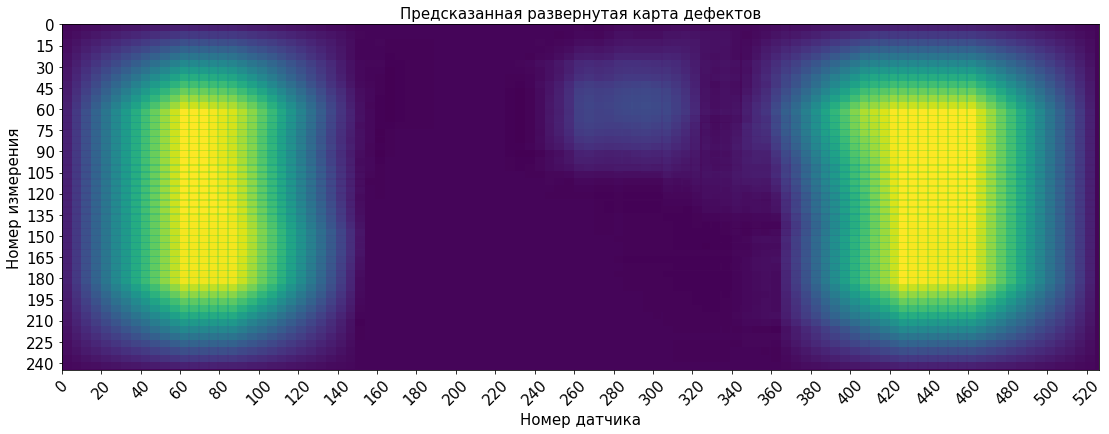

In [35]:
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(map_0)
axes.invert_yaxis()
axes.set_xlabel('Номер датчика', fontsize=15) 
axes.set_ylabel('Номер измерения', fontsize=15) 
axes.set_title(f'Предсказанная развернутая карта дефектов', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes.yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes.yaxis.set_tick_params(which = 'major', labelsize = 15) 

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
plt.show()

## Умное построение карты

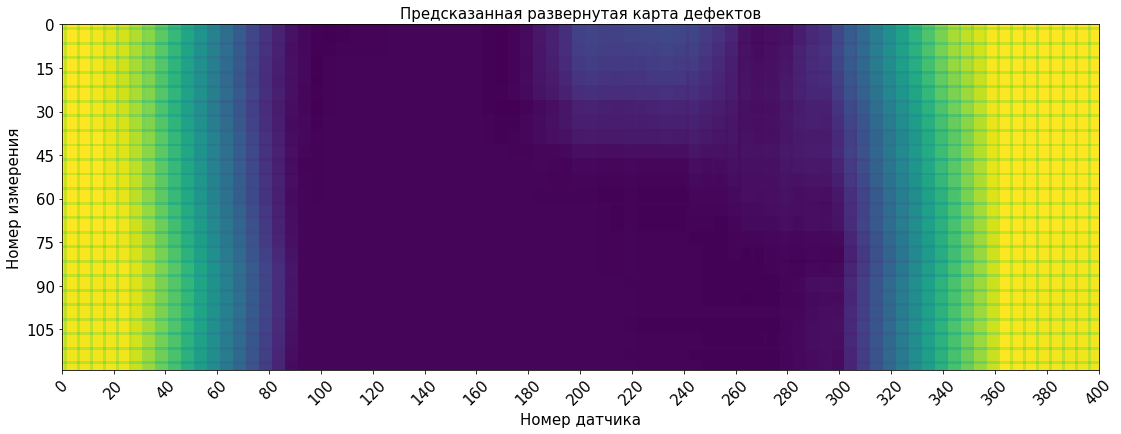

In [36]:
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(map_2)
axes.invert_yaxis()
axes.set_xlabel('Номер датчика', fontsize=15) 
axes.set_ylabel('Номер измерения', fontsize=15) 
axes.set_title(f'Предсказанная развернутая карта дефектов', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes.yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
 
#  Устанавливаем форматирование делений: 
axes.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes.yaxis.set_tick_params(which = 'major', labelsize = 15) 

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
plt.show()